<a href="https://colab.research.google.com/github/AroojArifNU/DLTest/blob/main/Colab_Notebooks/CIFAR_RESNNET_SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install adversarial-robustness-toolbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 32.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.20.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.3 which is incompatible.


In [3]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.models import load_model

if tf.__version__[0] == "2":
    tf.compat.v1.disable_eager_execution()

from art import config
from art.utils import load_dataset, get_file
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod
from art.defences.detector.evasion import BinaryInputDetector

import numpy as np
import matplotlib.pyplot as plt

# **Load Cifar Dataset**

In [4]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset('cifar10')



In [ ]:
x_train.shape

(50000, 32, 32, 3)

# **Load pretrained Resnet**

In [5]:
from tensorflow.keras.models import load_model

# Load pre-trained model
model = load_model('/content/drive/MyDrive/ColabNotebooks/CIFAR/cifar_resnet.h5')
classifier_model = model
# # classifier_model = load_model(path)
classifier = KerasClassifier(clip_values=(min_, max_), model=classifier_model, use_logits=False,
                              preprocessing=(0.5, 1))

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_1 (Conv2D)           (None, 32, 32, 16)           448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization_1 (Bat  (None, 32, 32, 16)           64        ['conv2d_1[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation_1 (Activation)   (None, 32, 32, 16)           0         ['batch_normalization_1[

In [6]:
x_test_pred = np.argmax(model.predict(x_test), axis=1)
nb_correct_pred = np.sum(x_test_pred == np.argmax(y_test, axis=1))

print("Original test data ( 1000 images):")
print("Correctly classified: {}".format(nb_correct_pred))


Original test data ( 1000 images):
Correctly classified: 8333


# **Extract Correct Examples**

In [7]:
import numpy as np

# Assuming x_test is your test data and y_test are the true labels
# And classifier.predict(x_test) is how you obtain predictions

x_test_pred = np.argmax(model.predict(x_test), axis=1)
true_labels = np.argmax(y_test, axis=1)

# Identify correctly classified examples
correct_indices = np.where(x_test_pred == true_labels)[0]
correct_examples = x_test[correct_indices]
correct_labels = y_test[correct_indices]

# Count correctly and incorrectly classified examples
nb_correct_pred = len(correct_indices)
nb_incorrect_pred = len(x_test) - nb_correct_pred

print("Original test data (1000 images):")
print("Correctly classified: {}".format(nb_correct_pred))
print("Incorrectly classified: {}".format(nb_incorrect_pred))

# Optionally, save the correctly classified examples and labels
# np.save('correct_examples.npy', correct_examples)
# np.save('correct_labels.npy', correct_labels)


Original test data (1000 images):
Correctly classified: 8333
Incorrectly classified: 1667


In [8]:
from sklearn.metrics import accuracy_score

# Check model's accuracy and confidence
predictions = model.predict(correct_examples)
confidence = np.max(predictions, axis=1)
print("Model accuracy:", accuracy_score(np.argmax(correct_labels, axis=1), np.argmax(predictions, axis=1)))
print("Average confidence of predictions:", np.mean(confidence))


Model accuracy: 1.0
Average confidence of predictions: 0.9748734


# **Equally Distributed Samples for Each class**

In [9]:
import numpy as np

# Assuming you have loaded CIFAR-10 data and labels
# x_adv_loaded, correct_examples, correct_labels are available

# Define the number of examples to select per class
examples_per_class = 50  # 50 examples (25 correct, 25 adversarial) per class for a total of 1000 examples

# Initialize empty lists to store selected examples and labels
selected_correct_examples = []
selected_labels = []  # New list to store corresponding class labels

# Initialize dictionaries to keep track of selected examples per class
selected_examples_per_class_correct = {}


# Shuffle the indices to randomly select examples
shuffled_indices = np.arange(len(correct_examples))
np.random.shuffle(shuffled_indices)

# Iterate through shuffled indices
for idx in shuffled_indices:
    correct_example = correct_examples[idx]
    correct_label = np.argmax(correct_labels[idx])  # Convert one-hot encoding to integer label


    # Check if the class (as an integer) is already present in selected_examples_per_class
    if correct_label not in selected_examples_per_class_correct:
        selected_examples_per_class_correct[correct_label] = 0


    # Check if we have selected enough examples for this class
    if (
        selected_examples_per_class_correct[correct_label] < examples_per_class // 2
    ):
        selected_examples_per_class_correct[correct_label] += 1
        selected_labels.append(correct_label)  # Add the corresponding label
        selected_correct_examples.append(correct_example)

    # Check if we have selected enough examples overall
    if len(selected_labels) == examples_per_class * len(selected_examples_per_class_correct):
        break

# Convert selected examples and labels to NumPy arrays
selected_correct_examples = np.array(selected_correct_examples)
selected_labels = np.array(selected_labels)


In [10]:
selected_correct_examples.shape

(250, 32, 32, 3)

In [11]:
x_test_pred = np.argmax(model.predict(selected_correct_examples), axis=1)
nb_correct_pred = np.sum(x_test_pred == selected_labels)

print("Original test data (  images):")
print("Correctly classified: {}".format(nb_correct_pred))
def calculate_accuracy(predictions, ground_truth):
    correct = np.sum(predictions == ground_truth)
    total = len(ground_truth)
    accuracy = correct / total
    return accuracy*100

accuracy_original = calculate_accuracy(x_test_pred, selected_labels)

Original test data (  images):
Correctly classified: 250


In [ ]:
accuracy_original

100.0

# **Generating Test Cases using PGD and Epsilon 0.03**

In [12]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import pickle
from art.attacks.evasion import FastGradientMethod, BasicIterativeMethod, ProjectedGradientDescent, DeepFool
from art.estimators.classification import TensorFlowV2Classifier  # Adjust based on your model framework


# List of attacks to be evaluated
attacks = [ProjectedGradientDescent]

# Define the range of eps values
eps_range = [0.03]
results = []
def perform_and_save_attack(attack_class, eps, x_examples, y_true, classifier, attack_name):
    """
    Perform an attack, return the accuracy, adversarial examples, and true labels, and save the adversarial examples with labels.
    """
    attack = attack_class(classifier, eps=eps)
    x_adv = attack.generate(x=x_examples)
    y_pred_adv = np.argmax(classifier.predict(x_adv), axis=1)

    if len(y_true.shape) > 1 and y_true.shape[1] > 1:
        y_true_flat = np.argmax(y_true, axis=1)
    else:
        y_true_flat = y_true

    accuracy_adv = accuracy_score(y_true_flat, y_pred_adv)

    # Save the adversarial examples and their true labels
    save_path = f'/content/drive/MyDrive/ColabNotebooks/CIFAR/{attack_name}_eps_{eps}.pkl'
    with open(save_path, 'wb') as f:
        pickle.dump({'x_adv': x_adv, 'y_true': y_true}, f)

    return accuracy_adv, x_adv, y_true

# Dictionary to store adversarial examples and labels
adversarial_data = {}

# Evaluate each attack at each epsilon value and save the adversarial examples
for attack in attacks:
    for eps in eps_range:
        accuracy_adv, x_adv, y_true_adv = perform_and_save_attack(attack, eps, selected_correct_examples, selected_labels, classifier, attack.__name__)
        results.append({
            'Attack': attack.__name__,
            'Epsilon': eps,
            'Accuracy': accuracy_adv
        })
        # Storing adversarial examples and labels in the dictionary
        adversarial_data[f'{attack.__name__}_eps_{eps}'] = {'x_adv': x_adv, 'y_true': y_true_adv}

# Now, `adversarial_data` contains all the adversarial examples and labels for further use


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

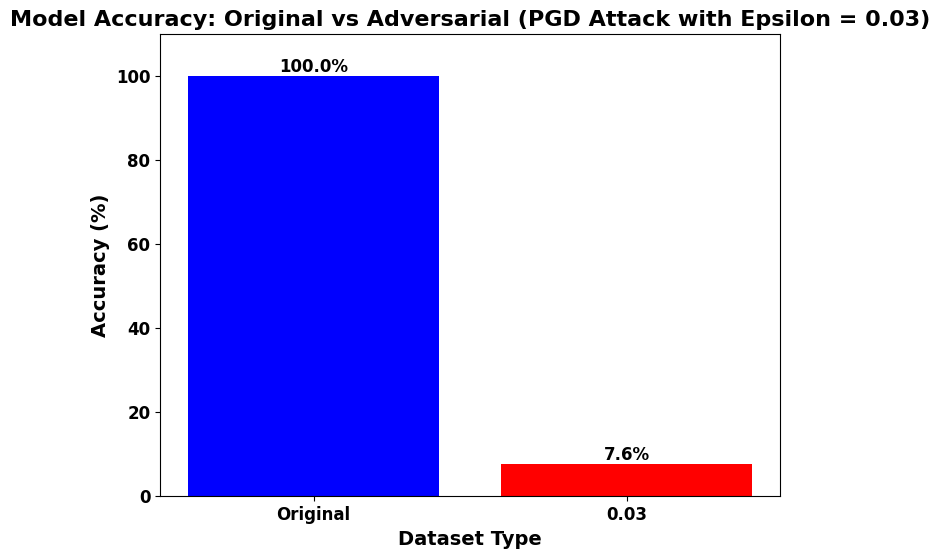

In [15]:
import matplotlib.pyplot as plt

# Assuming 'accuracy_original' and 'accuracy_adv' as before
accuracy_original = 100  # Original accuracy in percentage
accuracy_adv = results[0]['Accuracy'] * 100  # Convert to percentage for consistency

epsilons = ['Original', '0.03']
accuracies = [accuracy_original, accuracy_adv]

plt.figure(figsize=(8, 6))
bars = plt.bar(epsilons, accuracies, color=['blue', 'red'])
plt.xlabel('Dataset Type', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
plt.title('Model Accuracy: Original vs Adversarial (PGD Attack with Epsilon = 0.03)', fontsize=16, fontweight='bold')
plt.ylim(0, 110)

# Adjusting font size for axis ticks
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Adding a numerical label above each bar in larger font
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{round(yval, 2)}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Save the figure as a PNG file
plt.savefig('model_accuracy_comparison.png', bbox_inches='tight')

plt.show()


In [16]:
import pickle

def load_adversarial_data(file_path):
    """
    Load adversarial examples and labels from a pickle file.

    Parameters:
    - file_path: The path to the pickle file containing the saved adversarial examples and labels.

    Returns:
    - A dictionary with keys 'x_adv' and 'y_true' corresponding to the adversarial examples and their true labels.
    """
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

# Example usage
file_path = '/content/drive/MyDrive/ColabNotebooks/CIFAR/ProjectedGradientDescent_eps_0.03.pkl'
loaded_data = load_adversarial_data(file_path)

# Accessing the adversarial examples and labels
x_adv_loaded = loaded_data['x_adv']
y_true_loaded = loaded_data['y_true']

# Now, `x_adv_loaded` and `y_true_loaded` can be used for further analysis or evaluation


In [17]:
x_test_pred = np.argmax(model.predict(x_adv_loaded), axis=1)
nb_correct_pred = np.sum(x_test_pred == selected_labels)

print("Original test data ( images):")
print("Correctly classified: {}".format(nb_correct_pred))
def calculate_accuracy(predictions, ground_truth):
    correct = np.sum(predictions == ground_truth)
    total = len(ground_truth)
    accuracy = correct / total
    return accuracy

accuracy_adv = calculate_accuracy(x_test_pred, selected_labels)

Original test data ( images):
Correctly classified: 56


In [18]:
accuracy_adv

0.224

# **Comaparsion Correct and Adversarial**

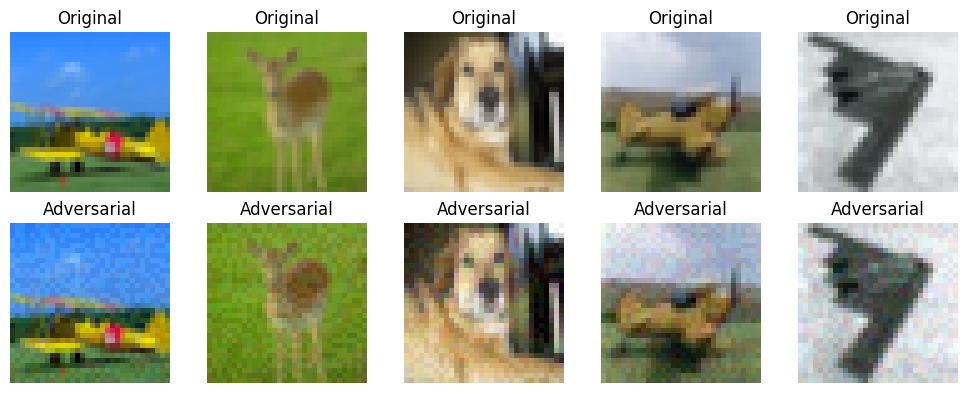

In [19]:
import matplotlib.pyplot as plt

def plot_comparison(original, adversarial, num_examples=5):
    """
    Plot a comparison between original and adversarial examples.

    Parameters:
    - original: NumPy array of original examples.
    - adversarial: NumPy array of adversarial examples, corresponding to the original examples.
    - num_examples: Number of examples to plot.
    """
    plt.figure(figsize=(2*num_examples, 4))
    for i in range(num_examples):
        # Plot original example
        plt.subplot(2, num_examples, i+1)
        plt.imshow(original[i].squeeze(), cmap='gray' if original[i].shape[-1] == 1 else None)
        plt.title("Original")
        plt.axis('off')

        # Plot adversarial example
        plt.subplot(2, num_examples, num_examples+i+1)
        plt.imshow(adversarial[i].squeeze(), cmap='gray' if adversarial[i].shape[-1] == 1 else None)
        plt.title("Adversarial")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Assuming `x_adv_loaded` is your loaded adversarial examples and `correct_examples` are your original examples
# Example usage:
plot_comparison(selected_correct_examples, x_adv_loaded, num_examples=5)


# **Calculating Perturbation Magnitude**

In [20]:
# def calculate_perturbation(original, perturbed):
#     l2_norm = np.linalg.norm(original - perturbed)
#     linf_norm = np.max(np.abs(original - perturbed))
#     return l2_norm, linf_norm

# # Example usage
# l2_norm, linf_norm = calculate_perturbation(selected_correct_examples, x_adv_loaded)
# print("L2 Norm:", l2_norm, "L-Infinity Norm:", linf_norm)


L2 Norm: 26.087695518644985 L-Infinity Norm: 0.030000029591953026


# **SHAP**
SHAP Value Integration: To deepen our analysis, we utilized SHAP (SHapley Additive exPlanations) values to pinpoint features that significantly influence model predictions. This enabled us to tailor perturbations to the most impactful areas of the input data, offering a nuanced view of model sensitivity and resilience.

In [21]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 9.4 MB/s eta 0:00:00


In [ ]:
# from keras.models import Model

# # Assuming 'model' is your original Keras model
# penultimate_layer = model.layers[-2]  # Adjust index according to your model architecture
# penultimate_output = penultimate_layer.output

# # Create a new model that outputs the penultimate layer
# model_penultimate = Model(inputs=model.input, outputs=penultimate_output)
# # Create a new model that outputs the penultimate layer# Assuming 'model' is your Keras model
# model.summary()  # This will print out the summary of the model, check the penultimate layer

# # Let's say your penultimate layer is the second last layer in the model
# # You can access it directly by index
# penultimate_layer = model.layers[-2]
# num_neurons_penultimate = penultimate_layer.output_shape[1]  # This is typically a tuple (None, number_of_neurons)

# print("Number of neurons in penultimate layer:", num_neurons_penultimate)



In [22]:
import shap
# Background data for SHAP (a subset of normal examples)
background_data = [correct_examples[:5000]]
# Initialize SHAP Deep Explainer
explainer = shap.GradientExplainer(model, background_data)

In [23]:
# Check model's accuracy and confidence
predictions = model.predict(selected_correct_examples)
confidence = np.max(predictions, axis=1)
print("Model accuracy:", accuracy_score(selected_labels, np.argmax(predictions, axis=1)))
print("Average confidence of predictions:", np.mean(confidence))


Model accuracy: 1.0
Average confidence of predictions: 0.9741642


In [24]:
import pickle

# Compute SHAP values for correct examples
correct_shap_values = explainer.shap_values(selected_correct_examples)

# Compute SHAP values for adversarial examples
adversarial_shap_values = explainer.shap_values(x_adv_loaded)

# Create a dictionary to store SHAP values along with their respective keys or indices
shap_values_dict = {
    'correct_examples': correct_shap_values,
    'adversarial_examples': adversarial_shap_values
}

# Define the filename for the pickle file
pickle_filename = '/content/drive/MyDrive/ColabNotebooks/CIFAR/shap_values.pkl'

# Save the SHAP values dictionary to a pickle file
with open(pickle_filename, 'wb') as file:
    pickle.dump(shap_values_dict, file)


In [26]:
import pickle

# Define the filename for the pickle file
pickle_filename = '/content/drive/MyDrive/ColabNotebooks/CIFAR/shap_values.pkl'

# Load the SHAP values dictionary from the pickle file
with open(pickle_filename, 'rb') as file:
    shap_values_dict = pickle.load(file)

# Access SHAP values for correct and adversarial examples
correct_shap_values = shap_values_dict['correct_examples']
adversarial_shap_values = shap_values_dict['adversarial_examples']

# Now you can use correct_shap_values and adversarial_shap_values as needed


In [27]:
correct_shap_values[0].shape

(250, 32, 32, 3)

In [28]:
adversarial_shap_values[0].shape

(250, 32, 32, 3)

# **Adjust Brightness Based on High SHAP Values for Correct Examples**

Leveraging SHAP (SHapley Additive exPlanations) values to guide perturbation testing represents a pioneering intersection between model interpretability and robustness enhancement. By identifying and adjusting the brightness of pixels that significantly influence model predictions, this approach not only scrutinizes the model's sensitivity to changes in key features but also uncovers potential vulnerabilities in its decision-making process.

In [127]:
def calculate_model_accuracy(model, images, true_labels):
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(true_labels, predicted_labels)
    return accuracy
def get_high_positive_shap_masks_correct(shap_values_correct, thresholds=[80, 85, 90]):
    """
    Generates boolean masks for pixels with high positive SHAP values across given thresholds
    for correct images.

    Parameters:
    - shap_values_correct: The SHAP values for the correct images. Assuming shape is (num_images, height, width, channels).
    - thresholds: List of percentile thresholds to apply.

    Returns:
    - A dictionary with keys as thresholds and values as lists of boolean masks for each image.
    """
    high_positive_shap_masks_correct = {threshold: [] for threshold in thresholds}

    for threshold in thresholds:
        # Determine the cutoff value for each threshold
        cutoff = np.percentile(shap_values_correct, threshold)

        # Generate a mask for each image based on the cutoff for positive SHAP values
        for i in range(shap_values_correct.shape[0]):
            mask = shap_values_correct[i] > cutoff
            high_positive_shap_masks_correct[threshold].append(mask)

    return high_positive_shap_masks_correct

# Generate high positive SHAP masks for correct examples
thresholds = [80, 85, 90]
high_positive_shap_masks_correct = get_high_positive_shap_masks_correct(correct_shap_values[0], thresholds)

def adjust_brightness_for_high_shap_pixels_correct(correct_images, shap_masks, adjustment_factor=0.5):
    """
    Adjusts the brightness of high SHAP value pixels in correct images.

    Parameters:
    - correct_images: The correct images to be adjusted.
    - shap_masks: Boolean masks indicating high SHAP value pixels.
    - adjustment_factor: Factor to adjust the brightness, <1 to darken, >1 to brighten.

    Returns:
    - Array of correct images with adjusted brightness for high SHAP value pixels.
    """
    adjusted_images = []
    for i in range(len(correct_images)):
        adjusted_image = np.copy(correct_images[i])
        high_shap_pixels = shap_masks[i]
        adjusted_image[high_shap_pixels] = np.clip(adjusted_image[high_shap_pixels] * adjustment_factor, 0, 1)
        adjusted_images.append(adjusted_image)
    return np.array(adjusted_images)

def calculate_and_plot_accuracies_brightness_adjustment(correct_images, high_positive_shap_pixels_correct, model, selected_labels, thresholds=[80, 85, 90], adjustment_factor=0.5):
    accuracies = []

    for threshold in thresholds:
        shap_masks_correct = high_positive_shap_pixels_correct[threshold]

        adjusted_images = adjust_brightness_for_high_shap_pixels_correct(correct_images, shap_masks_correct, adjustment_factor)
        accuracy = calculate_model_accuracy(model, adjusted_images, selected_labels)
        accuracies.append(accuracy * 100)
        print(f'Accuracy after brightness adjustment for correct examples at {threshold}% threshold: {accuracy * 100:.2f}%')

    #  # Plot the accuracies as a bar chart
    # plt.figure(figsize=(10, 6))
    # plt.bar(thresholds, accuracies, label='Correct Examples Brightness Adjustment', alpha=0.7)
    # plt.xlabel('SHAP Value Threshold (%)')
    # plt.ylabel('Model Accuracy (%)')
    # plt.title('Model Accuracy vs. SHAP Value Threshold for Correct Examples After Brightness Adjustment')
    # plt.xticks(thresholds)
    # plt.grid(axis='y')
    # plt.legend()
    # plt.tight_layout()
    # plt.show()

# Assuming `selected_correct_examples`, `high_positive_shap_masks_correct`, `model`, and `selected_labels` are defined
calculate_and_plot_accuracies_brightness_adjustment(selected_correct_examples, high_positive_shap_masks_correct, model, selected_labels)


Accuracy after brightness adjustment for correct examples at 80% threshold: 41.20%
Accuracy after brightness adjustment for correct examples at 85% threshold: 45.20%
Accuracy after brightness adjustment for correct examples at 90% threshold: 55.20%


# **Perturb High SHAP Value Pixels in Adversarial Examples**
The integration of SHAP (SHapley Additive exPlanations) values into the analysis of adversarial examples presents a novel perspective on bolstering the robustness of machine learning models. By identifying pixels with high positive SHAP values, which strongly influence model predictions, and directly replacing these pixels with their counterparts from original images, this approach systematically fortifies the model's resilience against adversarial attacks. . The resulting improvements in model accuracy under various SHAP value thresholds demonstrate the efficacy of this innovative approach in adversarial example mitigation

In [125]:
def get_high_positive_shap_masks(shap_values, thresholds=[80, 85, 90]):
    """
    Generates boolean masks for pixels with high positive SHAP values across given thresholds.

    Parameters:
    - shap_values: The SHAP values for the images. Assuming shape is (num_images, height, width, channels).
    - thresholds: List of percentile thresholds to apply.

    Returns:
    - A dictionary with keys as thresholds and values as lists of boolean masks for each image.
    """
    high_positive_shap_masks = {threshold: [] for threshold in thresholds}

    for threshold in thresholds:
        # Determine the cutoff value for each threshold
        cutoff = np.percentile(shap_values, threshold)

        # Generate a mask for each image based on the cutoff for positive SHAP values
        for i in range(shap_values.shape[0]):
            mask = shap_values[i] > cutoff
            high_positive_shap_masks[threshold].append(mask)

    return high_positive_shap_masks




high_positive_shap_pixels_adversarial = get_high_positive_shap_masks(adversarial_shap_values[0], thresholds)




def replace_high_shap_pixels_adversarial(adversarial_images, shap_masks, original_images):
    """
    Replaces high SHAP value pixels in adversarial images with the corresponding pixels from original images.

    Parameters:
    - adversarial_images: The adversarial images to be perturbed.
    - shap_masks: Boolean masks indicating high SHAP value pixels.
    - original_images: The original images for reference.

    Returns:
    - Array of adversarial images with high SHAP value pixels replaced by those from the original images.
    """
    perturbed_images = []
    for i in range(len(adversarial_images)):
        perturbed_image = np.copy(adversarial_images[i])
        # Directly replace high SHAP value pixels with those from the original image
        high_shap_pixels = shap_masks[i]
        perturbed_image[high_shap_pixels] = original_images[i][high_shap_pixels]
        perturbed_images.append(perturbed_image)
    return np.array(perturbed_images)
def calculate_and_plot_accuracies_direct_replacement(adversarial_images, high_positive_shap_pixels_adversarial, original_images, model, selected_labels, thresholds=[80, 85, 90]):
    accuracies = []

    for threshold in thresholds:
        shap_masks_adversarial = high_positive_shap_pixels_adversarial[threshold]

        perturbed_images = replace_high_shap_pixels_adversarial(adversarial_images, shap_masks_adversarial, original_images)
        accuracy = calculate_model_accuracy(model, perturbed_images, selected_labels)
        accuracies.append(accuracy * 100)
        print(f'Accuracy after directly replacing adversarial example pixels for {threshold}% threshold: {accuracy * 100:.2f}%')

    # # Plot the accuracies as a bar chart
    # plt.figure(figsize=(10, 6))
    # plt.bar(thresholds, accuracies, label='Adversarial Examples', alpha=0.7)
    # plt.xlabel('SHAP Value Threshold (%)')
    # plt.ylabel('Model Accuracy (%)')
    # plt.title('Model Accuracy vs. SHAP Value Threshold for Adversarial Examples (Direct Replacement)')
    # plt.xticks(thresholds)
    # plt.grid(axis='y')
    # plt.legend()
    # plt.tight_layout()
    # plt.show()
# Assuming `adversarial_examples`, `high_positive_shap_pixels_adversarial`, `selected_correct_examples`, `classifier`, and `selected_labels` are defined
calculate_and_plot_accuracies_direct_replacement(x_adv_loaded, high_positive_shap_pixels_adversarial, selected_correct_examples, model, selected_labels)


Accuracy after directly replacing adversarial example pixels for 80% threshold: 41.60%
Accuracy after directly replacing adversarial example pixels for 85% threshold: 34.00%
Accuracy after directly replacing adversarial example pixels for 90% threshold: 31.60%


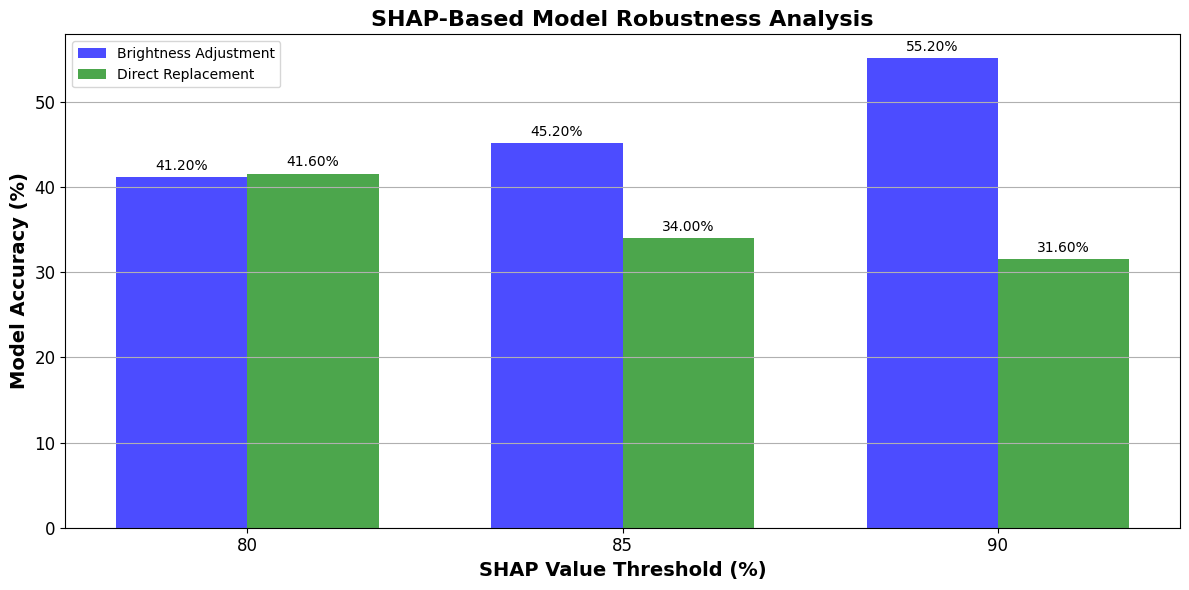

In [124]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_and_plot_accuracies_combined(correct_images, high_positive_shap_pixels_correct, adversarial_images, high_positive_shap_pixels_adversarial, original_images, model, selected_labels, thresholds=[80, 85, 90], adjustment_factor=0.5):
    brightness_accuracies = []
    direct_replacement_accuracies = []

    for threshold in thresholds:
        shap_masks_correct = high_positive_shap_pixels_correct[threshold]
        adjusted_images = adjust_brightness_for_high_shap_pixels_correct(correct_images, shap_masks_correct, adjustment_factor)
        brightness_accuracy = calculate_model_accuracy(model, adjusted_images, selected_labels)
        brightness_accuracies.append(brightness_accuracy * 100)

        shap_masks_adversarial = high_positive_shap_pixels_adversarial[threshold]
        perturbed_images = replace_high_shap_pixels_adversarial(adversarial_images, shap_masks_adversarial, original_images)
        direct_replacement_accuracy = calculate_model_accuracy(model, perturbed_images, selected_labels)
        direct_replacement_accuracies.append(direct_replacement_accuracy * 100)

    plt.figure(figsize=(12, 6))
    bar_width = 0.35
    index = np.arange(len(thresholds))

    # Create bar plots and add annotations
    brightness_bars = plt.bar(index, brightness_accuracies, bar_width, label='Brightness Adjustment', color='b', alpha=0.7)
    direct_replacement_bars = plt.bar(index + bar_width, direct_replacement_accuracies, bar_width, label='Direct Replacement', color='g', alpha=0.7)

    # Add annotations above each bar
    for bar in brightness_bars + direct_replacement_bars:
        height = bar.get_height()
        plt.annotate(f'{height:.2f}%',  # Display the accuracy value with two decimal places
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # Offset for the text position
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=10)

    plt.xlabel('SHAP Value Threshold (%)', fontsize=14, fontweight='bold')
    plt.ylabel('Model Accuracy (%)', fontsize=14, fontweight='bold')
    plt.title('SHAP-Based Model Robustness Analysis', fontsize=16, fontweight='bold')
    plt.xticks(index + bar_width / 2, thresholds, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y')
    plt.legend()
    plt.tight_layout()
    plt.savefig("shapmodelrobustness.png")
    plt.show()

# Assuming input data and parameters are defined for selected_correct_examples, high_positive_shap_masks_correct, x_adv_loaded, high_positive_shap_pixels_adversarial, classifier, and selected_labels
calculate_and_plot_accuracies_combined(selected_correct_examples, high_positive_shap_masks_correct, x_adv_loaded, high_positive_shap_pixels_adversarial, selected_correct_examples, model, selected_labels)


In [81]:

import numpy as np
import cv2

# ==================================
# Step 2: Define Perturbation Functions
# ==================================
# Function to add Gaussian noise to an image
def add_noise(image):
    noise = np.random.normal(0, 0.05, image.shape)
    noisy_image = np.clip(image + noise, 0, 1)
    return noisy_image

# Function to rotate an image by a given angle
def rotate_image(image, angle):
    center = (image.shape[1] // 2, image.shape[0] // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))
    return rotated_image

# Function to adjust the brightness of an image
def adjust_brightness(image, factor):
    bright_image = np.clip(image * factor, 0, 1)
    return bright_image

# Function to apply a specified perturbation to all images in a dataset
def apply_perturbation_to_all_images(images, perturbation_func, **kwargs):
    perturbed_images = np.array([perturbation_func(image, **kwargs) for image in images])
    return perturbed_images

def add_noise(image):
    noise = np.random.normal(0, 0.05, image.shape)
    noisy_image = np.clip(image + noise, 0, 1)
    return noisy_image

# Apply different perturbations to the dataset
all_correct_noisy = apply_perturbation_to_all_images(selected_correct_examples, add_noise)
all_correct_rotated = apply_perturbation_to_all_images(selected_correct_examples, rotate_image, angle=45)
all_correct_bright = apply_perturbation_to_all_images(selected_correct_examples, adjust_brightness, factor=1.5)

# # Example of using ImageDataGenerator for augmentation (optional)

# =============================
# Step 4: Calculate Model Accuracy
# =============================
# Define a function to calculate accuracy based on model predictions and true labels
def calculate_model_accuracy(model, images, true_labels):
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(true_labels, predicted_labels)
    return accuracy

# Calculate accuracies for different perturbation types
accuracy_noisy = calculate_model_accuracy(model, all_correct_noisy, selected_labels)
accuracy_rotated = calculate_model_accuracy(model,all_correct_rotated, selected_labels)
accuracy_bright = calculate_model_accuracy(model, all_correct_bright, selected_labels)

# Print out accuracies for each perturbation type
print(f"Accuracy (Noisy): {accuracy_noisy:.2f}")
print(f"Accuracy (Rotated): {accuracy_rotated:.2f}")
print(f"Accuracy (Brightness Adjusted): {accuracy_bright:.2f}")

# =============================


Accuracy (Noisy): 0.69
Accuracy (Rotated): 0.26
Accuracy (Brightness Adjusted): 0.85


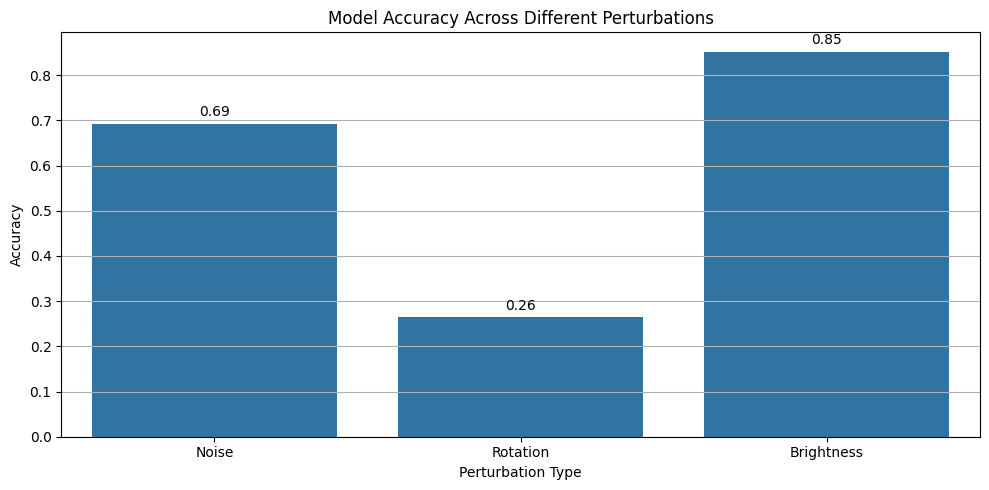

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'accuracies' contains accuracy scores for different perturbations
perturbations = [ 'Noise', 'Rotation', 'Brightness']
accuracies = [accuracy_noisy, accuracy_rotated, accuracy_bright]  # Example values

plt.figure(figsize=(10, 5))
ax = sns.barplot(x=perturbations, y=accuracies)

# Adding the text on top of each bar
for i, value in enumerate(accuracies):
    ax.text(i, value + 0.01, f'{value:.2f}', ha='center', va='bottom')

plt.xlabel('Perturbation Type')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Across Different Perturbations')
plt.grid(axis='y')

plt.tight_layout()
plt.savefig("DifferentPerturbations.png")
plt.show()


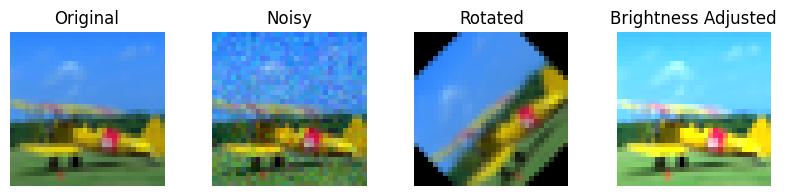

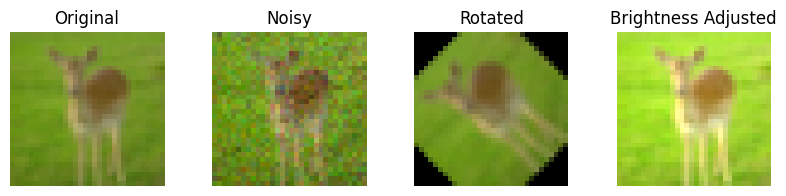

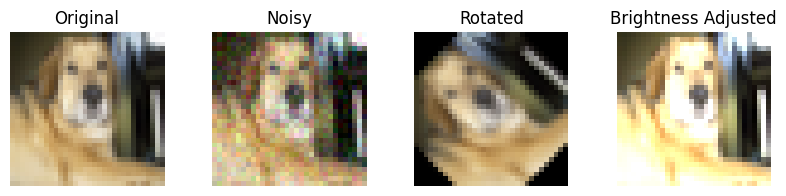

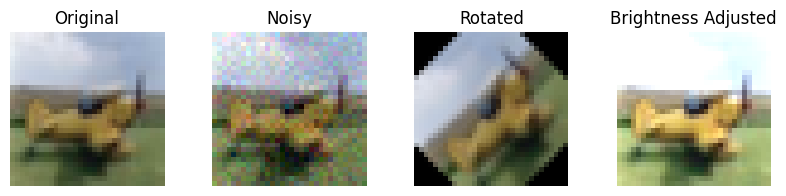

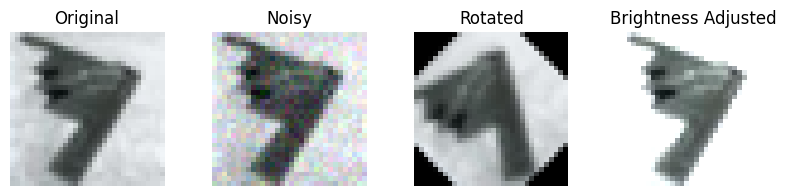

In [35]:
import matplotlib.pyplot as plt

def visualize_images(image_list, title_list, figsize=(20, 10), num_examples=5):
    """
    Visualizes a limited number of images with corresponding titles.

    Parameters:
    - image_list: List of images to be displayed.
    - title_list: List of titles for each image.
    - figsize: Tuple indicating figure size.
    - num_examples: The number of examples to display (default is 5).
    """
    # Ensure we do not exceed the list size or the desired number of examples
    n = min(len(image_list), num_examples)
    plt.figure(figsize=figsize)
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(image_list[i])
        plt.title(title_list[i])
        plt.axis('off')
    plt.show()

# Example usage with 5 examples
# Generate or select 5 specific examples and their titles
example_indices = [0, 1, 2, 3, 4]  # Just as an example, select the first 5 indices
selected_images = [selected_correct_examples[i] for i in example_indices]
noisy_images = [all_correct_noisy[i] for i in example_indices]
rotated_images = [all_correct_rotated[i] for i in example_indices]
brightness_adjusted_images = [all_correct_bright[i] for i in example_indices]

# Display each type of image modification in sequence for comparison
for i in range(len(example_indices)):
    visualize_images(
        [selected_images[i], noisy_images[i], rotated_images[i], brightness_adjusted_images[i]],
        ["Original", "Noisy", "Rotated", "Brightness Adjusted"],
        figsize=(10, 2)  # Adjust figure size as needed for visibility
    )


# **Robustness Sensitivity Analysis **
 We developed a framework for applying multiple types of perturbations—specifically, noise (both Gaussian and salt-and-pepper), rotation at various angles, and brightness adjustments—to input images. This approach allows us to simulate real-world variations and adversarial conditions that the model might encounter post-deployment.

Noise_{'noise_type': 'gaussian', 'mean': 0, 'var': 0.01}: 0.37%
Noise_{'noise_type': 'gaussian', 'mean': 0, 'var': 0.05}: 0.11%
Noise_{'noise_type': 'salt_pepper', 's_vs_p': 0.5, 'amount': 0.004}: 0.09%
Noise_{'noise_type': 'salt_pepper', 's_vs_p': 0.5, 'amount': 0.01}: 0.10%
Rotation_-45: 0.29%
Rotation_0: 1.00%
Rotation_45: 0.26%
Rotation_90: 0.30%
Brightness_0.5: 0.89%
Brightness_1.0: 1.00%
Brightness_1.5: 0.85%


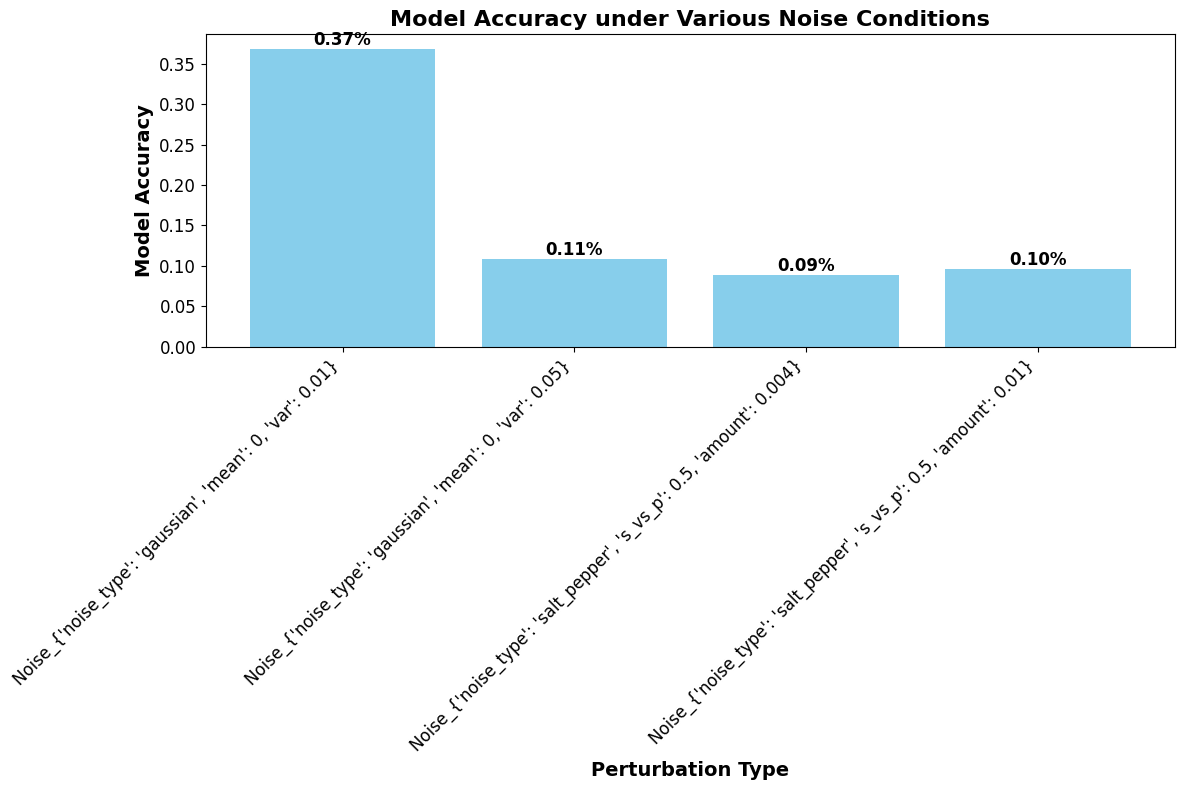

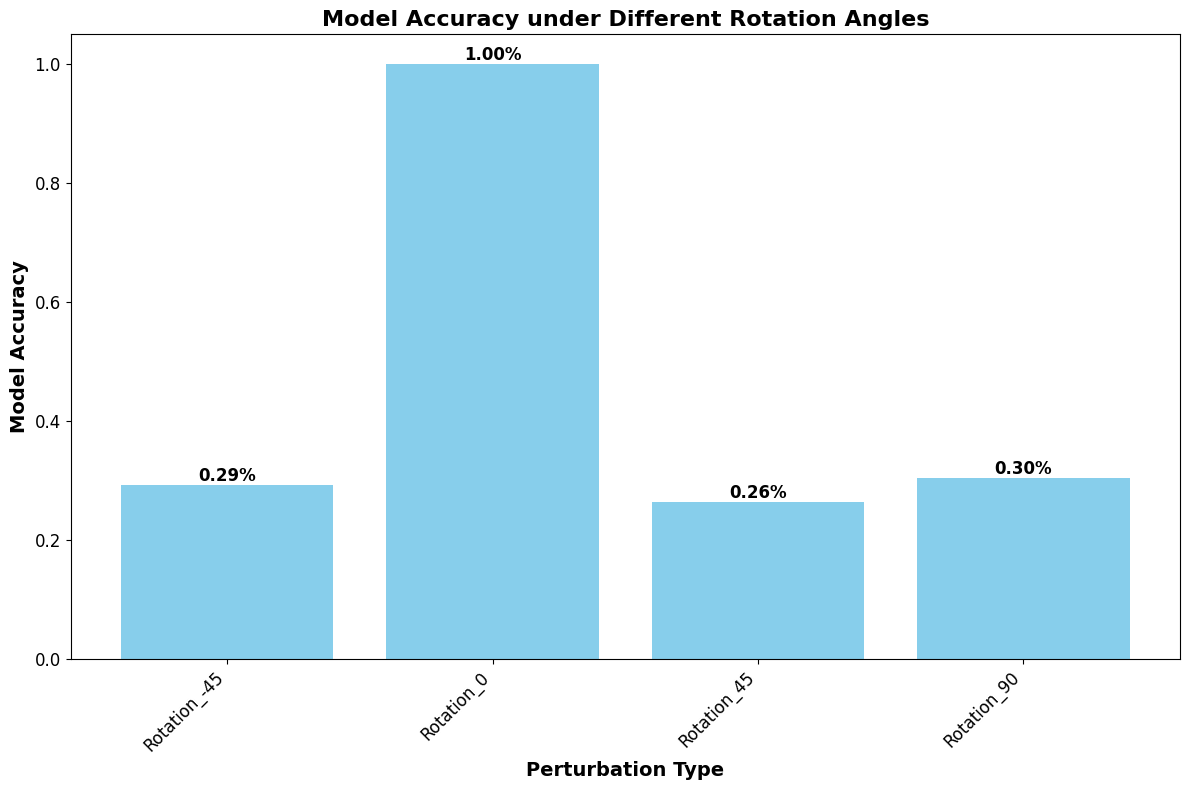

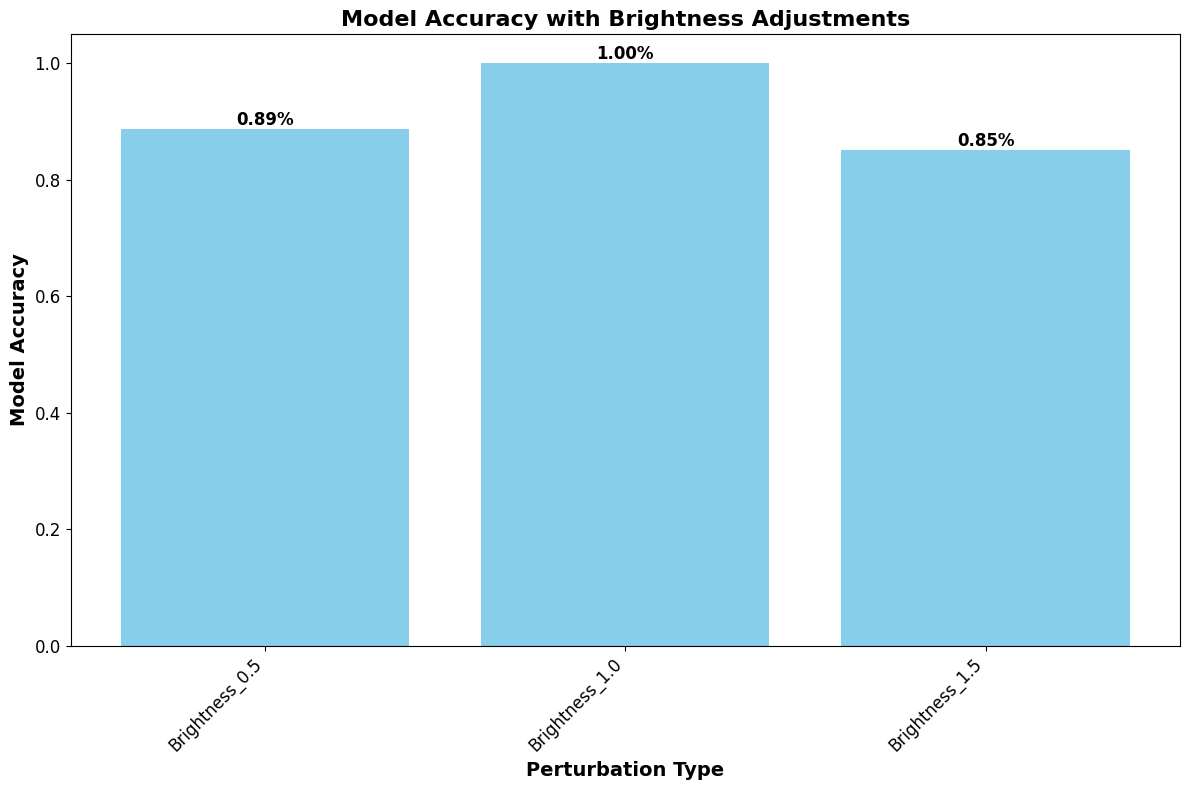

In [41]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score


def add_noise(image, noise_type="gaussian", **kwargs):
    if noise_type == "gaussian":
        mean = kwargs.get('mean', 0)
        var = kwargs.get('var', 0.01)
        sigma = var ** 0.5
        gauss = np.random.normal(mean, sigma, image.shape)
        noisy = np.clip(image + gauss, 0, 1)
    elif noise_type == "salt_pepper":
        s_vs_p = kwargs.get('s_vs_p', 0.5)
        amount = kwargs.get('amount', 0.004)
        noisy = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
        noisy[coords] = 1
        # Pepper mode
        num_pepper = np.ceil(amount * image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
        noisy[coords] = 0
    return noisy
# Function to rotate an image by a given angle
def rotate_image(image, angle):
    center = (image.shape[1] // 2, image.shape[0] // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))
    return rotated_image

# Function to adjust the brightness of an image
def adjust_brightness(image, factor):
    bright_image = np.clip(image * factor, 0, 1)
    return bright_image

def apply_perturbations(images, perturbation_func, **kwargs):
    return np.array([perturbation_func(image, **kwargs) for image in images])

def evaluate_model(model, images, labels):
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels, predicted_labels)
    return accuracy

# Example usage
noise_configs = [
    {"noise_type": "gaussian", "mean": 0, "var": 0.01},
    {"noise_type": "gaussian", "mean": 0, "var": 0.05},
    {"noise_type": "salt_pepper", "s_vs_p": 0.5, "amount": 0.004},
    {"noise_type": "salt_pepper", "s_vs_p": 0.5, "amount": 0.01}
]

rotation_angles = [-45, 0, 45, 90]

brightness_factors = [0.5, 1.0, 1.5]

results = {}

for config in noise_configs:
    perturbed_images = apply_perturbations(selected_correct_examples, add_noise, **config)
    accuracy = evaluate_model(model, perturbed_images, selected_labels)
    results[f"Noise_{config}"] = accuracy

for angle in rotation_angles:
    perturbed_images = apply_perturbations(selected_correct_examples, rotate_image, angle=angle)
    accuracy = evaluate_model(model, perturbed_images, selected_labels)
    results[f"Rotation_{angle}"] = accuracy

for factor in brightness_factors:
    perturbed_images = apply_perturbations(selected_correct_examples, adjust_brightness, factor=factor)
    accuracy = evaluate_model(model, perturbed_images, selected_labels)
    results[f"Brightness_{factor}"] = accuracy

# Print or log the results for analysis
for perturbation, accuracy in results.items():
    print(f"{perturbation}: {accuracy:.2f}%")

import matplotlib.pyplot as plt

# Assuming 'results' is your dictionary containing the accuracy for each perturbation

# Organize data for plotting
noise_data = {k: v for k, v in results.items() if 'Noise' in k}
rotation_data = {k: v for k, v in results.items() if 'Rotation' in k}
brightness_data = {k: v for k, v in results.items() if 'Brightness' in k}

def plot_data(data, title, save_filename):
    labels = list(data.keys())
    accuracies = list(data.values())

    # Plotting
    plt.figure(figsize=(12, 8))
    plt.bar(labels, accuracies, color='skyblue')
    plt.xlabel('Perturbation Type', fontsize=14, fontweight='bold')
    plt.ylabel('Model Accuracy', fontsize=14, fontweight='bold')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, ha="right", fontsize=12)
    plt.yticks(fontsize=12)

    # Add values on top of the bars
    for i, v in enumerate(accuracies):
        plt.text(i, v, f'{v:.2f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

    # Add annotations to the bars
    for i, annotation in enumerate(labels):
        plt.annotate(annotation, (i, accuracies[i] + 2), ha='center', fontsize=12, fontweight='bold')

    plt.tight_layout()  # Adjust layout to not cut off labels
    plt.savefig(save_filename)
    plt.show()

# Plot for each perturbation type and save separately
plot_data(noise_data, 'Model Accuracy under Various Noise Conditions', 'noise_accuracy_plot.png')
plot_data(rotation_data, 'Model Accuracy under Different Rotation Angles', 'rotation_accuracy_plot.png')
plot_data(brightness_data, 'Model Accuracy with Brightness Adjustments', 'brightness_accuracy_plot.png')



# **Composite Perturbation Testing**
Composite Perturbation Testing: By combining these perturbations, we created complex testing scenarios that mimic challenging environmental conditions. This multifactorial analysis goes beyond traditional single-factor testing to uncover interactions and compounded effects of different perturbations on model performance.

In [46]:
def apply_combined_perturbations(image, rotation_angle, brightness_factor, noise_config):
    # Rotate image
    rotated = rotate_image(image, angle=rotation_angle)
    # Adjust brightness
    brightened = adjust_brightness(rotated, factor=brightness_factor)
    # Add noise
    noisy = add_noise(brightened, **noise_config)
    return noisy

# Example configuration for combined perturbations
combined_configs = [
    {'rotation_angle': 30, 'brightness_factor': 1.2, 'noise_config': {"noise_type": "gaussian", "mean": 0, "var": 0.02}},
]

for config in combined_configs:
    perturbed_images = np.array([
        apply_combined_perturbations(image, **config) for image in selected_correct_examples
    ])
    accuracy = evaluate_model(model, perturbed_images, selected_labels)
    config_desc = f"Combined_{config}"
    results[config_desc] = accuracy

def apply_combined_perturbations(image, rotation_angle, brightness_factor, noise_config):
    # Rotate image
    rotated = rotate_image(image, angle=rotation_angle)
    # Adjust brightness
    brightened = adjust_brightness(rotated, factor=brightness_factor)
    # Add noise
    noisy = add_noise(brightened, **noise_config)
    return noisy

# Example configuration for combined perturbations
combined_configs = [
    {'rotation_angle': 30, 'brightness_factor': 1.2, 'noise_config': {"noise_type": "gaussian", "mean": 0, "var": 0.02}},
]

for config in combined_configs:
    perturbed_images = np.array([
        apply_combined_perturbations(image, **config) for image in selected_correct_examples
    ])
    accuracy = evaluate_model(model, perturbed_images, selected_labels)
    config_desc = f"Combined_{config}"
    results[config_desc] = accuracy



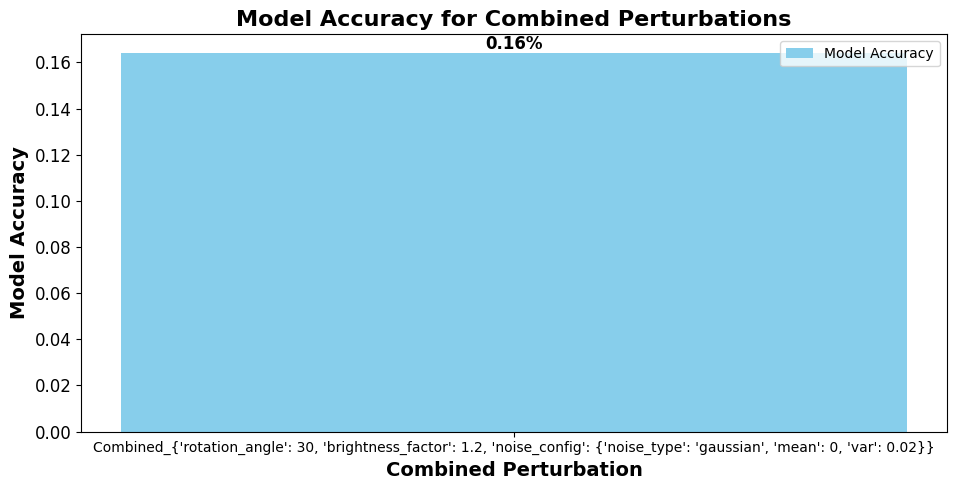

In [58]:
import numpy as np
import matplotlib.pyplot as plt

# Organize data for plotting
combined_data = {k: v for k, v in results.items() if 'Combined' in k}

def plot_combined_data_grouped(data, title, save_filename):
    labels = list(data.keys())
    accuracies = list(data.values())
    num_configs = len(labels)

    # Define width for each group
    bar_width = 0.35
    index = np.arange(num_configs)

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.bar(index, accuracies, bar_width, color='skyblue', label='Model Accuracy')

    # Add labels, title, and legend
    plt.xlabel('Combined Perturbation', fontsize=14, fontweight='bold')
    plt.ylabel('Model Accuracy', fontsize=14, fontweight='bold')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xticks(index, labels, fontsize=10)  # Decrease font size here
    plt.yticks(fontsize=12)
    plt.legend()

    # Add values on top of the bars
    for i, v in enumerate(accuracies):
        plt.text(i, v, f'{v:.2f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.tight_layout()  # Adjust layout to not cut off labels
    plt.savefig(save_filename)
    plt.show()

# Plot the combined data using grouped bar plot
plot_combined_data_grouped(combined_data, 'Model Accuracy for Combined Perturbations', 'combined_accuracy_grouped_plot.png')


# **Augmentation Strategy Evaluation**
By employing a comprehensive parameter grid to explore a wide spectrum of augmentations, from basic geometric transformations to complex composite modifications, this method provides a deep understanding of how different perturbations affect model accuracy. It empowers us to identify optimal augmentation strategies that significantly enhance model robustness and generalizability across diverse input conditions. This not only aids in developing more resilient models capable of withstanding real-world variability but also sets a foundation for future explorations into adaptive augmentation frameworks.

In [61]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import accuracy_score

# Assuming 'selected_correct_examples' and 'selected_labels' are predefined with appropriate shapes
# For instance, selected_correct_examples.shape = (num_samples, height, width, channels)
# And selected_labels is a list or numpy array of labels

# Define your data augmentation strategy
data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

augmented_images = []
augmented_labels = []

# Define how many augmented images you want per original image
augmentations_per_image = 5

# Iterate over the dataset once and generate augmented images
for i in range(len(selected_correct_examples)):
    # Get a single image and label
    image = selected_correct_examples[i:i+1]  # Add an extra dimension to match the batch shape
    label = selected_labels[i]

    # Initialize the iterator outside the inner loop
    iterator = data_generator.flow(image, batch_size=1)

    # Generate 'augmentations_per_image' new images
    for _ in range(augmentations_per_image):
        augmented_image = next(iterator)[0].astype('float32')  # Obtain the next image from iterator

        # Store the augmented image and its label
        augmented_images.append(augmented_image)
        augmented_labels.append(label)  # Append the specific label for this image

# Convert lists to numpy arrays for model processing
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Ensure labels are in the correct format for model evaluation
# If your model expects categorical labels, use to_categorical
# augmented_labels = to_categorical(augmented_labels, num_classes=NUM_CLASSES)

# Evaluate the model's performance on the augmented dataset
predictions = model.predict(augmented_images)
predicted_labels = np.argmax(predictions, axis=1)

# Compute accuracy if labels are not one-hot encoded; otherwise, adjust accordingly
accuracy = accuracy_score(augmented_labels, predicted_labels)
print(f"Accuracy on augmented test set: {accuracy*100:.2f}%")


Accuracy on augmented test set: 71.36%


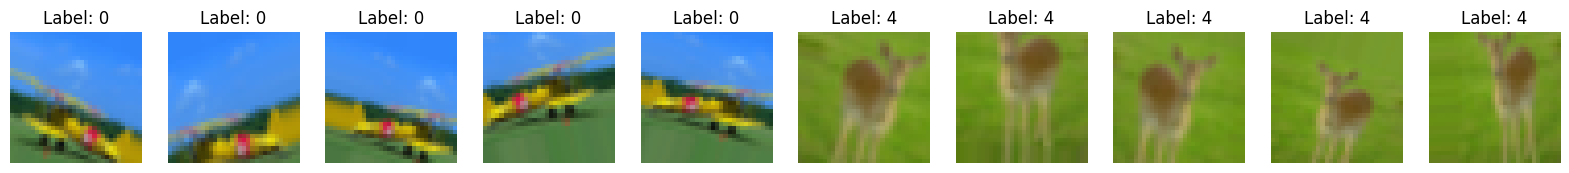

In [62]:
import matplotlib.pyplot as plt

# Function to visualize a subset of the augmented images
def visualize_augmented_images(images, labels, num_images=10):
    plt.figure(figsize=(20, 4))

    # Select a subset of images to visualize
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])

        # Assuming labels are integer class IDs
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')

    plt.show()

# Assuming 'augmented_images' and 'augmented_labels' are available from the previous code
visualize_augmented_images(augmented_images, augmented_labels, num_images=10)


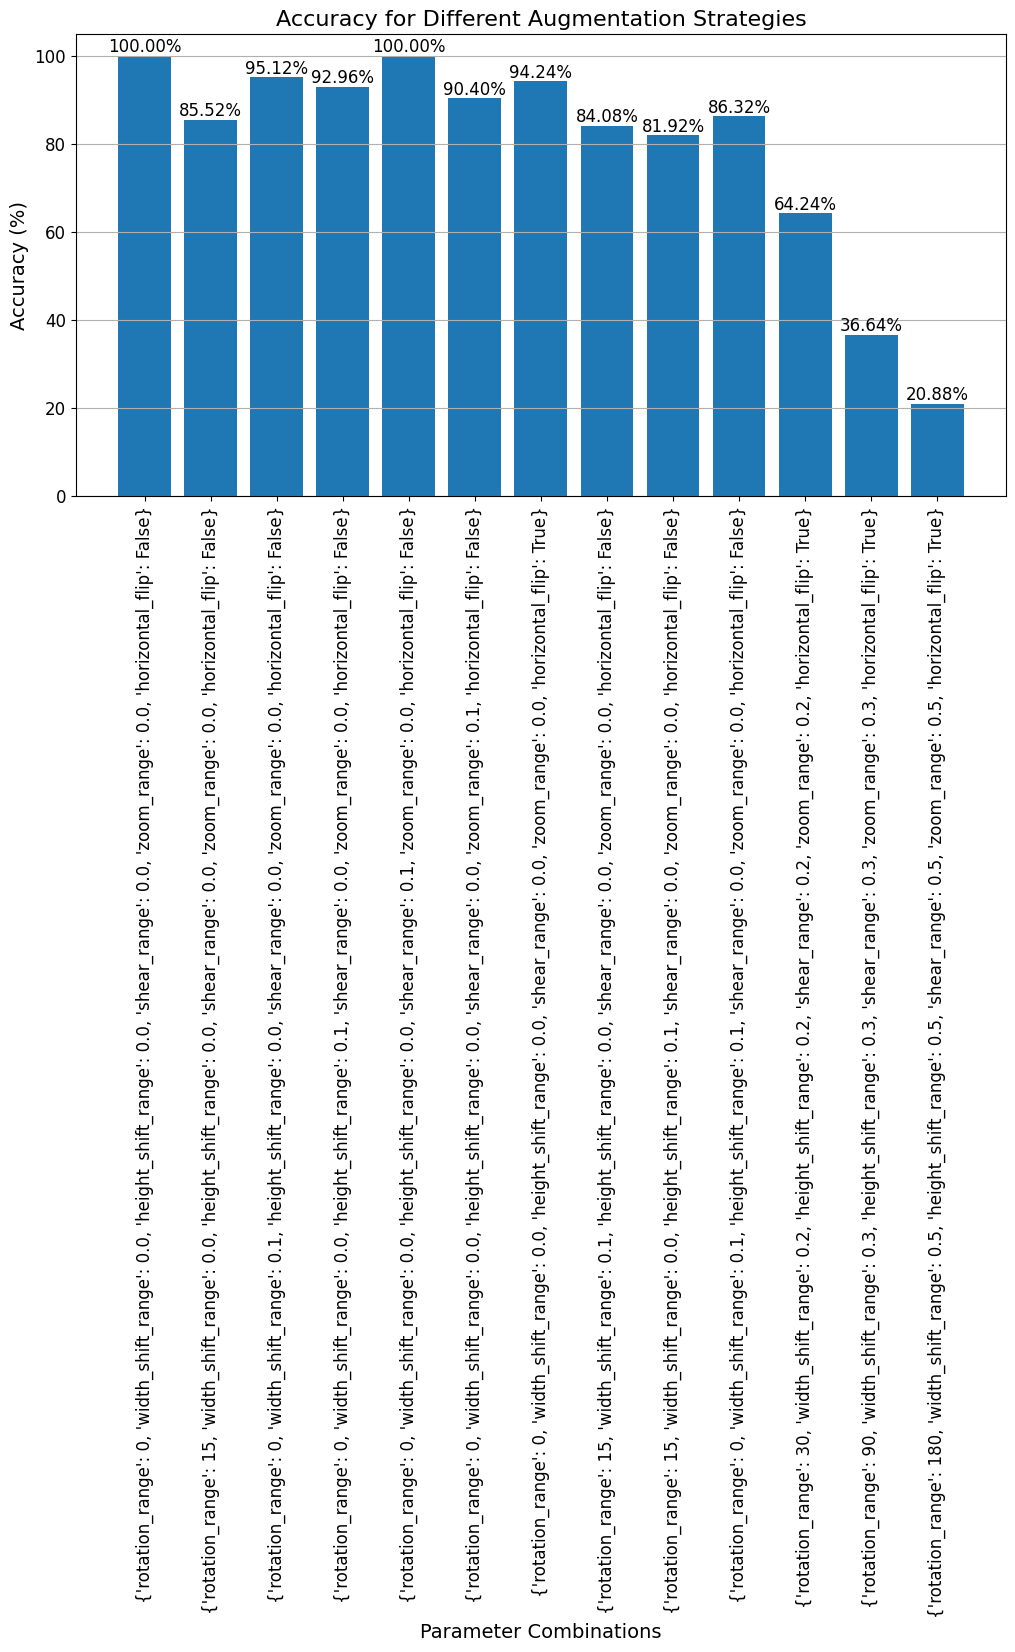

In [63]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Define a parameter grid for experimentation
param_grid = [
    # No augmentation
    {'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'shear_range': 0.0, 'zoom_range': 0.0, 'horizontal_flip': False},

    # Individual augmentations at mild levels
    {'rotation_range': 15, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'shear_range': 0.0, 'zoom_range': 0.0, 'horizontal_flip': False},
    {'rotation_range': 0, 'width_shift_range': 0.1, 'height_shift_range': 0.0, 'shear_range': 0.0, 'zoom_range': 0.0, 'horizontal_flip': False},
    {'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.1, 'shear_range': 0.0, 'zoom_range': 0.0, 'horizontal_flip': False},
    {'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'shear_range': 0.1, 'zoom_range': 0.0, 'horizontal_flip': False},
    {'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'shear_range': 0.0, 'zoom_range': 0.1, 'horizontal_flip': False},
    {'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'shear_range': 0.0, 'zoom_range': 0.0, 'horizontal_flip': True},

    # Combinations of two augmentations
    {'rotation_range': 15, 'width_shift_range': 0.1, 'height_shift_range': 0.0, 'shear_range': 0.0, 'zoom_range': 0.0, 'horizontal_flip': False},
    {'rotation_range': 15, 'width_shift_range': 0.0, 'height_shift_range': 0.1, 'shear_range': 0.0, 'zoom_range': 0.0, 'horizontal_flip': False},
    {'rotation_range': 0, 'width_shift_range': 0.1, 'height_shift_range': 0.1, 'shear_range': 0.0, 'zoom_range': 0.0, 'horizontal_flip': False},
    # More combinations can be added similarly

    # Aggressive augmentation
    {'rotation_range': 30, 'width_shift_range': 0.2, 'height_shift_range': 0.2, 'shear_range': 0.2, 'zoom_range': 0.2, 'horizontal_flip': True},

    # Extreme cases for stress testing
    {'rotation_range': 90, 'width_shift_range': 0.3, 'height_shift_range': 0.3, 'shear_range': 0.3, 'zoom_range': 0.3, 'horizontal_flip': True},
    {'rotation_range': 180, 'width_shift_range': 0.5, 'height_shift_range': 0.5, 'shear_range': 0.5, 'zoom_range': 0.5, 'horizontal_flip': True}
]

# Initialize lists to store results
results = []


# Assume 'selected_correct_examples' and 'selected_labels' are predefined
# Ensure 'model' is correctly defined and compiled

augmentations_per_image = 5  # Define how many augmented images you want per original image

# Update the loop for generating augmented images and labels
for params in param_grid:
    data_generator = ImageDataGenerator(**params)
    augmented_images, augmented_labels = [], []

    # Assuming 'selected_correct_examples' is a NumPy array and 'selected_labels' are correctly formatted
    iterator = data_generator.flow(selected_correct_examples, selected_labels, batch_size=1)

    for _ in range(len(selected_correct_examples) * augmentations_per_image):
        batch_imgs, batch_labels = next(iterator)
        augmented_images.append(batch_imgs[0])
        augmented_labels.append(batch_labels[0])

    augmented_images = np.array(augmented_images)

    # If labels were initially one-hot encoded, adjust 'true_labels' calculation accordingly
    if len(augmented_labels[0].shape) > 1:  # Assuming one-hot encoding
        true_labels = np.argmax(np.array(augmented_labels), axis=1)
    else:
        true_labels = np.array(augmented_labels)

    predictions = model.predict(augmented_images)
    predicted_labels = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(true_labels, predicted_labels)

    results.append({'params': params, 'accuracy': accuracy})

# Continue with plotting results as before

# Extract parameters and accuracies for plotting
param_names = [str(params) for params in param_grid]
accuracies = [result['accuracy'] * 100 for result in results]

# Create a bar plot with annotations
plt.figure(figsize=(12, 6))
plt.bar(param_names, accuracies)
plt.xlabel('Parameter Combinations', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.title('Accuracy for Different Augmentation Strategies', fontsize=16)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)

# Add annotations
for i, acc in enumerate(accuracies):
    plt.annotate(f'{acc:.2f}%', (i, acc), ha='center', va='bottom', fontsize=12)
plt.grid(axis='y')

plt.tight_layout()
plt.show()


In [64]:
augmented_images.shape

(1250, 32, 32, 3)

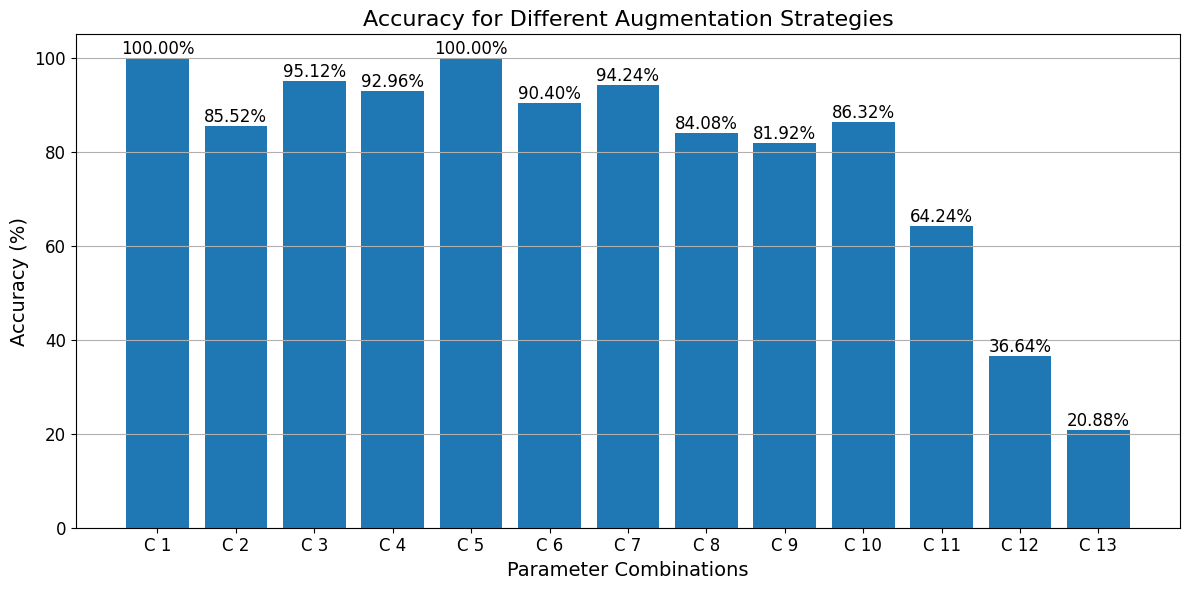

In [65]:
# Extract parameters and accuracies for plotting
param_names = [f'C {i+1}' for i, _ in enumerate(param_grid)]
accuracies = [result['accuracy'] * 100 for result in results]

# Create a bar plot with annotations
plt.figure(figsize=(12, 6))
plt.bar(param_names, accuracies)
plt.xlabel('Parameter Combinations', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.title('Accuracy for Different Augmentation Strategies', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add annotations
for i, acc in enumerate(accuracies):
    plt.annotate(f'{acc:.2f}%', (i, acc), ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.grid(axis='y')

plt.savefig("DifferentAugmentationStrategies.png")
plt.show()

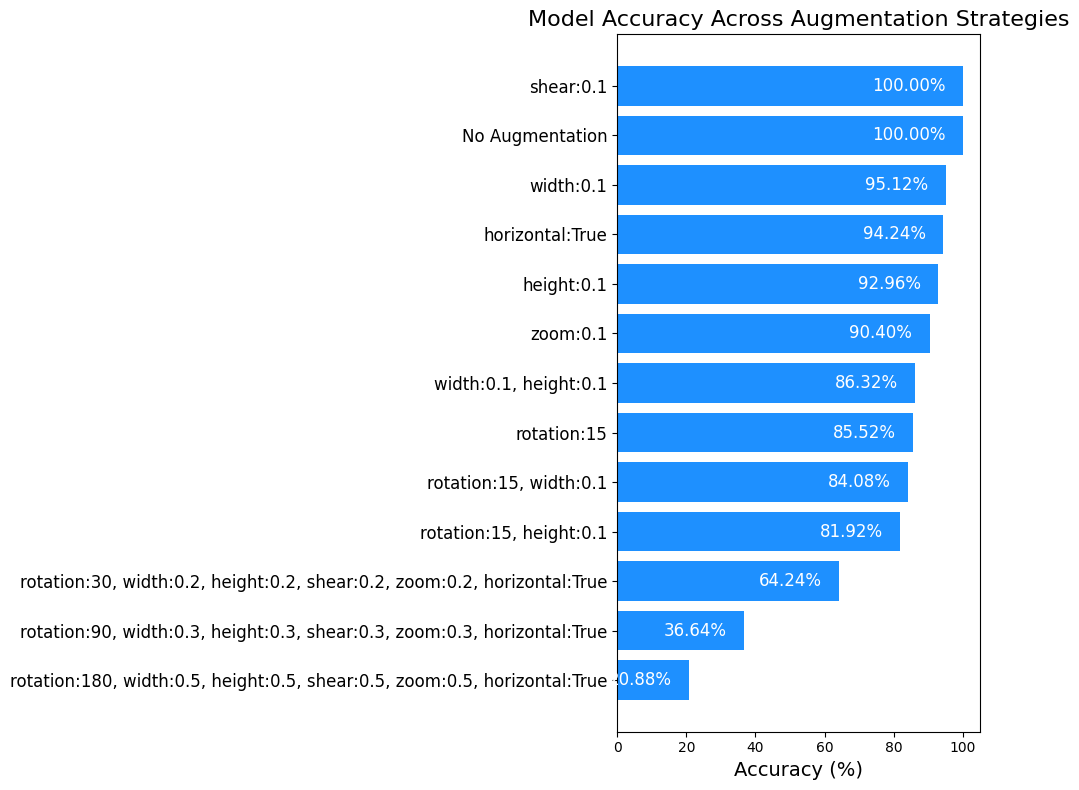

In [69]:
import matplotlib.pyplot as plt

# Assuming `results` is a list of dictionaries with 'params' and 'accuracy'

# Simplify parameter names for readability
def simplify_param_name(params):
    param_components = []
    for key, value in params.items():
        if value != 0 and value != False:
            param_components.append(f"{key.split('_')[0]}:{value}")
    return ", ".join(param_components) if param_components else "No Augmentation"

simplified_param_names = [simplify_param_name(result['params']) for result in results]
accuracies = [result['accuracy'] * 100 for result in results]

# Sorting results by accuracy for a more intuitive presentation
sorted_indices = np.argsort(accuracies)
sorted_param_names = np.array(simplified_param_names)[sorted_indices]
sorted_accuracies = np.array(accuracies)[sorted_indices]

plt.figure(figsize=(10, 8))
bars = plt.barh(range(len(sorted_param_names)), sorted_accuracies, color='dodgerblue')
plt.xlabel('Accuracy (%)', fontsize=14)
plt.title('Model Accuracy Across Augmentation Strategies', fontsize=16)
plt.yticks(range(len(sorted_param_names)), sorted_param_names, fontsize=12)

# Adding the accuracy values on the bar chart
for bar, acc in zip(bars, sorted_accuracies):
    plt.text(bar.get_width() - 5, bar.get_y() + bar.get_height() / 2,
             f'{acc:.2f}%', va='center', ha='right', color='white', fontsize=12)

plt.tight_layout()
plt.savefig("Model Accuracy Across Augmentation Strategies.png")
plt.show()


# **Modify Pixels of Original Image &  perturb_adversarial_with_original on different Thresholds**
Randomized Brightness Perturbation
This technique involves randomly selecting pixels within an image and adjusting their brightness to simulate localized lighting changes. By controlling the percentage of affected pixels, we can systematically explore the model's sensitivity to variations in illumination across the image. This approach mimics the uneven lighting conditions often found in natural settings, challenging the model's ability to maintain accuracy despite localized changes in visual features.

Adversarial-Original Hybrid Perturbation
Building on the concept of adversarial attacks, this method creates hybrid images by replacing a percentage of pixels in an adversarial image with their counterparts from the original, non-perturbed image. This technique tests the model's ability to correctly classify images that contain a blend of adversarial and original content, offering insights into the threshold at which adversarial perturbations begin to significantly impact model performance. It reflects the nuanced nature of real-world adversarial scenarios, where inputs may only be partially compromised.

In [128]:


def adjust_brightness_random_pixels(image, percentage_change):
    perturbed_image = np.copy(image)
    height, width, channels = image.shape
    num_pixels = int(percentage_change * height * width / 100)
    pixel_positions = np.random.choice(height * width, num_pixels, replace=False)

    for pixel_position in pixel_positions:
        row = pixel_position // width
        col = pixel_position % width
        perturbed_image[row, col] = np.clip(perturbed_image[row, col] * 0.5, 0, 1)

    return perturbed_image

# Example usage:
percentage_changes = [20, 15, 10]
accuracies = []

for percentage in percentage_changes:
    perturbed_images = [adjust_brightness_random_pixels(image, percentage) for image in selected_correct_examples]
    accuracy = calculate_model_accuracy(model,np.array(perturbed_images), selected_labels)
    accuracies.append(accuracy)

for i, percentage in enumerate(percentage_changes):
    print(f'Accuracy for {percentage}% brightness change: {accuracies[i] * 100:.2f}%')

###################################### perturb_adversarial_with_original#####################################

percentages = [20, 15, 10]

import numpy as np

def perturb_adversarial_with_original(adversarial_images, original_images, percentage):
    perturbed_images = []
    height, width = 32, 32  # Explicitly set for clarity, based on provided shapes

    for i in range(adversarial_images.shape[0]):
        adversarial_image = np.copy(adversarial_images[i])
        original_image = original_images[i]
        num_pixels = height * width  # 32 * 32 = 1024, as confirmed
        num_perturbed_pixels = int(percentage / 100 * num_pixels)

        # Debug: Print the number of pixels to be perturbed
        # print(f"Perturbing {num_perturbed_pixels} pixels out of {num_pixels} ({percentage}%) for image {i+1}")

        # Generating unique pixel positions for perturbation
        pixel_positions = np.random.choice(num_pixels, num_perturbed_pixels, replace=False)

        for pixel_position in pixel_positions:
            # Calculating row and column indices based on the flat pixel position
            row = pixel_position // width
            col = pixel_position % width

            # Safety check to catch any potential index error before it occurs
            if row >= height or col >= width:
                print(f"Out of bounds access attempt: Row {row}, Col {col}")
                continue  # Skip this iteration to avoid the IndexError

            adversarial_image[row, col, :] = original_image[row, col, :]

        perturbed_images.append(adversarial_image)

    return np.array(perturbed_images)


percentage_changes = [20, 15, 10]

for percentage in percentage_changes:
    perturbed_adversarial = perturb_adversarial_with_original(x_adv_loaded, selected_correct_examples, percentage)
    predictions = model.predict(perturbed_adversarial)

    correct_labels = selected_labels  # Ensure this matches the true labels accurately.
    predicted_labels = np.argmax(predictions, axis=1)
    print(f"Predictions ({percentage}% perturbation): {predicted_labels}")

    # Calculate accuracy and print it
    accuracy = accuracy_score(correct_labels, predicted_labels)
    print(f"Accuracy ({percentage}% Perturbation): {accuracy * 100:.2f}%")

    # Debug: Check if perturbation changes the distribution of predictions
    unique, counts = np.unique(predicted_labels, return_counts=True)
    print(f"Distribution of predicted labels for {percentage}% perturbation: {dict(zip(unique, counts))}")

Accuracy for 20% brightness change: 37.60%
Accuracy for 15% brightness change: 46.40%
Accuracy for 10% brightness change: 52.00%
Predictions (20% perturbation): [0 4 3 4 3 0 3 2 3 6 6 8 8 8 2 5 0 2 3 3 8 4 6 2 6 3 3 6 2 1 9 4 3 4 6 4 6
 6 6 2 6 3 4 2 2 3 3 2 5 5 3 1 6 0 3 8 4 3 3 3 6 4 6 8 0 1 8 2 6 8 3 7 6 9
 3 3 3 9 9 9 3 3 0 4 3 3 1 8 3 4 4 8 1 2 6 6 2 4 8 9 4 2 6 3 3 8 9 8 3 0 9
 1 5 3 3 8 3 1 3 3 3 6 9 9 2 3 4 3 3 0 4 6 6 0 4 8 8 4 3 4 4 4 9 8 0 3 8 0
 3 7 2 4 1 4 3 9 6 3 0 6 8 8 8 6 1 8 3 6 3 2 6 6 9 8 4 1 4 6 8 2 8 3 9 4 4
 2 4 8 3 6 3 3 4 9 6 3 3 9 5 6 3 8 6 6 8 6 3 8 6 6 4 2 7 8 2 3 6 3 9 8 6 6
 4 6 6 6 3 3 4 8 1 4 6 3 2 7 2 4 4 5 6 6 3 6 2 8 4 6 8 6]
Accuracy (20% Perturbation): 35.20%
Distribution of predicted labels for 20% perturbation: {0: 12, 1: 11, 2: 23, 3: 59, 4: 36, 5: 6, 6: 48, 7: 4, 8: 34, 9: 17}
Predictions (15% perturbation): [0 4 3 4 3 0 3 2 3 6 6 8 8 8 4 5 0 2 4 3 8 4 6 2 3 4 3 6 2 1 9 4 3 4 6 4 6
 6 6 2 6 3 3 2 2 4 3 2 5 5 3 1 6 0 3 8 6 3 3 3 6 4 2 0 8 1 8 2 2

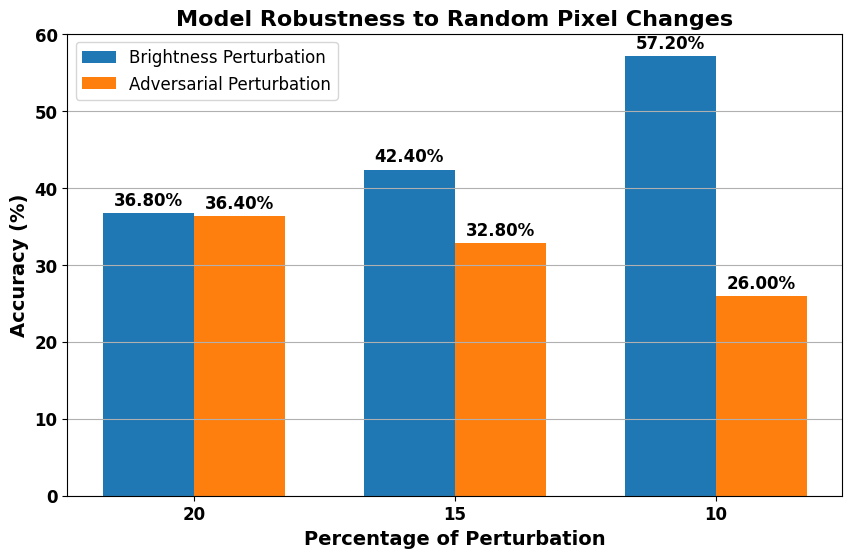

In [129]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

# Define the percentage changes for brightness perturbation and adversarial perturbation
percentage_changes = [20,15,10]

# Initialize lists to store accuracies for each type of perturbation
brightness_accuracies = []
adversarial_accuracies = []

# Calculate accuracies for brightness perturbation
for percentage in percentage_changes:
    perturbed_images = [adjust_brightness_random_pixels(image, percentage) for image in selected_correct_examples]
    accuracy = calculate_model_accuracy(model, np.array(perturbed_images), selected_labels)
    brightness_accuracies.append(accuracy)

# Calculate accuracies for adversarial perturbation
for percentage in percentage_changes:
    perturbed_adversarial = perturb_adversarial_with_original(x_adv_loaded, selected_correct_examples, percentage)
    predictions = model.predict(perturbed_adversarial)
    correct_labels = selected_labels  # Ensure this matches the true labels accurately.
    predicted_labels = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(correct_labels, predicted_labels)
    adversarial_accuracies.append(accuracy)

# Create a bar plot
plt.figure(figsize=(10, 6))
width = 0.35
x = np.arange(len(percentage_changes))

# Bar plot for brightness perturbation
plt.bar(x - width/2, [accuracy * 100 for accuracy in brightness_accuracies], width, label='Brightness Perturbation')

# Bar plot for adversarial perturbation
plt.bar(x + width/2, [accuracy * 100 for accuracy in adversarial_accuracies], width, label='Adversarial Perturbation')

plt.title('Model Robustness to Random Pixel Changes', fontsize=16, fontweight='bold')
plt.xlabel('Percentage of Perturbation', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
plt.xticks(x, percentage_changes, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(axis='y')

# Add annotations to the bars
for i in range(len(percentage_changes)):
    plt.annotate(f'{brightness_accuracies[i] * 100:.2f}%', (x[i] - width/2, brightness_accuracies[i] * 100 + 1), ha='center', fontsize=12, fontweight='bold')
    plt.annotate(f'{adversarial_accuracies[i] * 100:.2f}%', (x[i] + width/2, adversarial_accuracies[i] * 100 + 1), ha='center', fontsize=12, fontweight='bold')
plt.savefig("modelrobustnessonrandompixels.png")
plt.show()
